We'll Build a scaled down version of GPT-2 model, train it from scratch.

This is a good approach to take if you have a lot of data and it is very different from the pretraining data used for the available models. However, it also requires considerably more compute resources to pretrain a language model than just to fine-tune an existing one. Examples where it can make sense to train a new model include for datasets consisting of musical notes, molecular sequences such as DNA, or programming languages.

We will then use the Trainer API and 🤗 Accelerate to train the model. Let’s get to it!

**Gathering Dataset**


We'll use HuggingFace filtered version of `codeparrot` dataset.

In [ ]:
!pip -q install datasets tokenizers
!pip -q install accelerate

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from datasets import load_dataset, DatasetDict
ds_valid = load_dataset("huggingface-course/codeparrot-ds-valid", split="validation")

raw_datasets = DatasetDict(
    {
        "valid": ds_valid,  # .shuffle().select(range(500))
    })

raw_datasets

DatasetDict({
    valid: Dataset({
        features: ['repo_name', 'path', 'copies', 'size', 'content', 'license'],
        num_rows: 3322
    })
})

In [ ]:
# We’ll look at an example 200 characters of each field.
for key in raw_datasets["valid"][0]:
    print(f"{key.upper()}: {raw_datasets['valid'][0][key][:200]}")

REPO_NAME: ratnania/pigasus
PATH: doc/manual/include/demo/test_neumann_quartcircle.py
COPIES: 1
SIZE: 2730
CONTENT: #! /usr/bin/python

# ...
try:
    from matplotlib import pyplot as plt
    PLOT=True
except ImportError:
    PLOT=False
# ...
import numpy                as np
from pigasus.gallery.poisson import *
i
LICENSE: mit


**Prepare Dataset**

First step is to tokenizer the dataset. Here are going to fix the context length to 138 since we're doing just autocompletion of short sequnces. Larger context length comes with more GPU memory footprint.


Most documents contain many more than 128 tokens, so simply truncating the inputs to the maximum length would eliminate a large fraction of our dataset. Instead, we’ll use the `return_overflowing_tokens` option to tokenize the whole input and split it into several chunks.

We’ll also use the return_length option to return the length of each created chunk automatically. Often the last chunk will be smaller than the context size, and we’ll get rid of these pieces to avoid padding issues; we don’t really need them as we have plenty of data anyway.


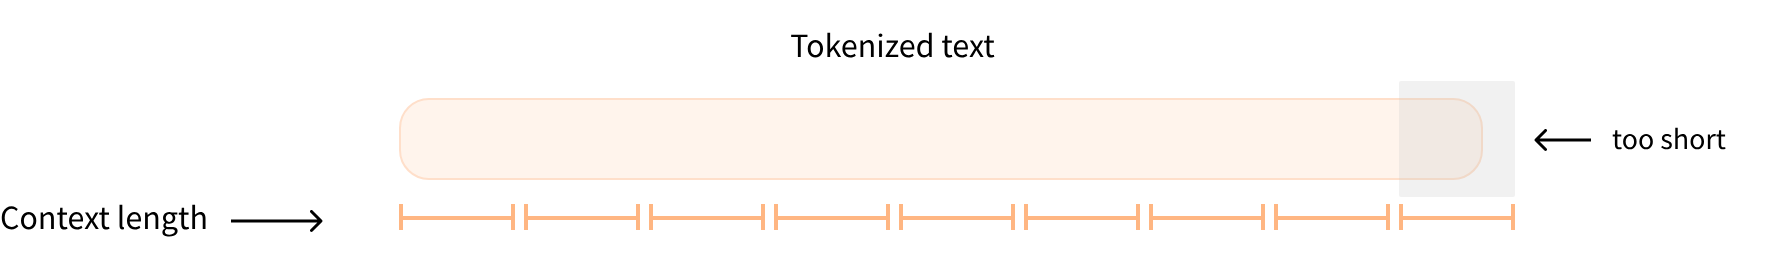

In [ ]:
from transformers import AutoTokenizer

context_length = 128
tokenizer = AutoTokenizer.from_pretrained("huggingface-course/code-search-net-tokenizer")

outputs = tokenizer(
    raw_datasets["valid"][:2]["content"],
    truncation=True,
    max_length=context_length,
    return_overflowing_tokens=True,
    return_length=True,
)

print(f"Input IDs length: {len(outputs['input_ids'])}")
print(f"Input chunk lengths: {(outputs['length'])}")
print(f"Chunk mapping: {outputs['overflow_to_sample_mapping']}")

Input IDs length: 17
Input chunk lengths: [128, 128, 128, 128, 128, 128, 128, 60, 128, 128, 128, 128, 128, 128, 128, 128, 111]
Chunk mapping: [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]


We got 34 segments in total from those examples. Looking at the chunk lengths we can see the ones at the end of both documnets have less than 128 (117 and 41).These represent just a small fraction of the total chunks that we have, so we can safely throw them away. With the `overflow_to_sample_mapping` field, we can also reconstruct which chunks belonged to which input samples.


With this operation we’re using a handy feature of the Dataset.map() function in 🤗 Datasets
- we can create batches with more or fewer elements than the input batch.
- This is useful when doing operations like data augmentation or data filtering that change the number of elements.
- In our case, when tokenizing each element into chunks of the specified context size
- We just need to make sure to delete the existing columns, since they have a conflicting size.

*We're using the `valid` set here to accomodate memory while training.*


In [ ]:
import os
os.cpu_count()

2

In [ ]:
def tokenize(element):
    outputs = tokenizer(
        element["content"],
        truncation=True,
        max_length=context_length,
        return_overflowing_tokens=True,
        return_length=True)

    input_batch = []

    for length, input_ids in zip(outputs["length"], outputs["input_ids"]):
        if length == context_length:
            input_batch.append(input_ids)

    return {"input_ids": input_batch}

tokenized_datasets = raw_datasets.map(tokenize, batched=True, remove_columns=raw_datasets["valid"].column_names, num_proc=2)

*We now have 16.7 million examples with 128 tokens each, which corresponds to about 2.1 billion tokens in total.*


**Initializing a new model**

We freshly initiliaze the GPT 2 model. We'll load the pretrained configuration and adjust to make sure that the tokenizer size matches the model vocabulary size and pass the `bos` and `eos`.

With that configuration we’re actually initializing a model ourself. Note that  we don’t use the `from_pretrained()` function.



In [ ]:
from transformers import AutoTokenizer, GPT2LMHeadModel, AutoConfig

config = AutoConfig.from_pretrained(
    "gpt2",
    vocab_size=len(tokenizer),
    n_ctx=context_length,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
)

model = GPT2LMHeadModel(config)
model_size = sum(t.numel() for t in model.parameters())
print(f"GPT-2 size: {model_size/1000**2:.1f}M parameters")

GPT-2 size: 124.2M parameters


We'll use 1B paramter TinyLlama model for this time to see how much time and resource does it take to train 1B param model.

```from huggingface_hub import notebook_login
notebook_login()```

Before we can start training, we need to set up a data collator that will take care of creating the batches. We can use the `DataCollatorForLanguageModeling` collator. Besides stacking and padding batches, it also takes care of creating the language model labels.

In causal language modeling the inputs serve as labels too (shifted by one element on the fly during training)

In [ ]:
from transformers import DataCollatorForLanguageModeling

tokenizer.pad_token = tokenizer.eos_token
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

# Lets look at an example

out = data_collator([tokenized_datasets["valid"][i] for i in range(5)])
for key in out:
    print(f"{key} shape: {out[key].shape}")

# We can see that the examples have been stacked and all the tensors have the same shape.

input_ids shape: torch.Size([5, 128])
attention_mask shape: torch.Size([5, 128])
labels shape: torch.Size([5, 128])


**Training Loop**

All that’s left to do is configure the training arguments and fire up the Trainer. We’ll use a cosine learning rate schedule with some warmup and an effective `batch size` of 256 (`per_device_train_batch_size * gradient_accumulation_steps`)

**Gradient accumulation**

In [ ]:
from transformers import Trainer, TrainingArguments

args = TrainingArguments(
    output_dir="codeparrot-ds",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    eval_strategy="steps",
    eval_steps=5_000,
    logging_steps=5_000,
    gradient_accumulation_steps=8,
    num_train_epochs=1,
    weight_decay=0.1,
    warmup_steps=1_000,
    lr_scheduler_type="cosine",
    learning_rate=5e-4,
    save_steps=5_000,
    fp16=True,
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=args,
    data_collator=data_collator,
    train_dataset=tokenized_datasets["valid"],
)

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=364, training_loss=6.0028699937757555, metrics={'train_runtime': 1054.3116, 'train_samples_per_second': 88.365, 'train_steps_per_second': 0.345, 'total_flos': 6085752717312000.0, 'train_loss': 6.0028699937757555, 'epoch': 1.0})

In [ ]:
trainer.push_to_hub()

CommitInfo(commit_url='https://huggingface.co/kailasps/codeparrot-ds/commit/8c1e544f68411bfa5fa1326bea3784b68ea78330', commit_message='End of training', commit_description='', oid='8c1e544f68411bfa5fa1326bea3784b68ea78330', pr_url=None, pr_revision=None, pr_num=None)